In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.data import Dataset
import keras_tuner
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 100)


In [126]:
season_dfs = list()
seasons = np.arange(2019, 2022)
for season in seasons:
    season_dfs.append(pd.read_csv(f"data/{season}.csv"))
df = pd.concat(season_dfs).reset_index(drop=True)
    

In [127]:
dummy_df = pd.get_dummies(df[['count', 'pitch_type_lag_1', 'pitch_type_lag_2']], prefix=['count', 'lag_1', 'lag_2'])
df = df.join(dummy_df)
df.head()


,game_id,inning,top,at_bat_index,home_score,away_score,outs,pitcher_name,pitcher_id,pitcher_lefty,batter_name,batter_id,batter_lefty,runner_1,runner_2,runner_3,balls,strikes,pitch_type,at_bat,raw_pitch_type,count,pitch_type_lag_1,pitch_type_lag_2,lag_1_ball,lag_1_strike,lag_2_ball,lag_2_strike,lag_3_ball,lag_3_strike,pitch_count,inning_pitch_count,ab_pitch_count,ab_changeup_count,ab_curveball_count,ab_cutter_count,ab_fastball_count,ab_knuckle_curve_count,ab_other_count,ab_sinker_count,ab_slider_count,ab_splitter_count,nth_season_pitch,fastball_rate,curveball_rate,sinker_rate,cutter_rate,changeup_rate,slider_rate,splitter_rate,other_rate,knuckle_curve_rate,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter
0,565248,1,True,0,0,0,0,Tanner Roark,543699,False,Adam Eaton,594809,True,False,False,False,0,0,fastball,0,Four-Seam Fastball,"(0,0)",none,none,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,565248,1,True,0,0,0,0,Tanner Roark,543699,False,Adam Eaton,594809,True,False,False,False,1,0,fastball,0,Four-Seam Fastball,"(1,0)",fastball,none,True,False,False,False,False,False,1,1,1,0,0,0,1,0,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,565248,1,True,0,0,0,0,Tanner Roark,543699,False,Adam Eaton,594809,True,False,False,False,1,1,curveball,0,Curveball,"(1,1)",fastball,fastball,False,True,True,True,False,False,2,2,2,0,0,0,2,0,0,0,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,565248,1,True,0,0,0,0,Tanner Roark,543699,False,Adam Eaton,594809,True,False,False,False,1,2,curveball,0,Curveball,"(1,2)",curveball,fastball,False,True,False,True,True,True,3,3,3,0,1,0,2,0,0,0,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,565248,1,True,0,0,0,0,Tanner Roark,543699,False,Adam Eaton,594809,True,False,False,False,2,2,fastball,0,Four-Seam Fastball,"(2,2)",curveball,curveball,True,False,True,True,True,True,4,4,4,0,2,0,2,0,0,0,0,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [128]:
pitch_types = list(df.pitch_type.unique())
direct_features = ['home_score', 'away_score', 'inning', 'top', 'outs', 'pitch_count', 'inning_pitch_count', 'ab_pitch_count', 'pitcher_lefty', 'batter_lefty']
direct_features.extend(['lag_1_ball', 'lag_1_strike'])
direct_features.extend(['runner_1', 'runner_2', 'runner_3'])
direct_features.extend([f"ab_{pitch_type}_count" for pitch_type in pitch_types])
features = direct_features + list(dummy_df.columns) + [c for c in df.columns if c.endswith("_rate")]
X = df.loc[df['raw_pitch_type'] != "other"].dropna(subset=features)[features]
y = df.loc[df['raw_pitch_type'] != "other"].dropna(subset=features)['pitch_type']
y = pd.get_dummies(y)
X.head()


,home_score,away_score,inning,top,outs,pitch_count,inning_pitch_count,ab_pitch_count,pitcher_lefty,batter_lefty,lag_1_ball,lag_1_strike,runner_1,runner_2,runner_3,ab_fastball_count,ab_curveball_count,ab_sinker_count,ab_cutter_count,ab_changeup_count,ab_slider_count,ab_splitter_count,ab_other_count,ab_knuckle_curve_count,"count_(0,0)","count_(0,1)","count_(0,2)","count_(1,0)","count_(1,1)","count_(1,2)","count_(2,0)","count_(2,1)","count_(2,2)","count_(3,0)","count_(3,1)","count_(3,2)",lag_1_changeup,lag_1_curveball,lag_1_cutter,lag_1_fastball,lag_1_knuckle_curve,lag_1_none,lag_1_other,lag_1_sinker,lag_1_slider,lag_1_splitter,lag_2_changeup,lag_2_curveball,lag_2_cutter,lag_2_fastball,lag_2_knuckle_curve,lag_2_none,lag_2_other,lag_2_sinker,lag_2_slider,lag_2_splitter,fastball_rate,curveball_rate,sinker_rate,cutter_rate,changeup_rate,slider_rate,splitter_rate,other_rate,knuckle_curve_rate
513,1,2,7,False,1,99,5,1,False,True,False,True,False,False,False,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.500000,0.130000,0.0,0.130000,0.130000,0.110000,0.0,0.0,0.0
514,1,2,7,False,1,100,6,2,False,True,False,True,False,False,False,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.504950,0.128713,0.0,0.128713,0.128713,0.108911,0.0,0.0,0.0
515,1,2,7,False,1,101,7,3,False,True,False,False,False,False,False,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.500000,0.127451,0.0,0.127451,0.137255,0.107843,0.0,0.0,0.0
516,1,2,7,False,1,102,8,4,False,True,True,False,False,False,False,2,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.495146,0.126214,0.0,0.126214,0.145631,0.106796,0.0,0.0,0.0
517,1,2,7,False,2,103,9,0,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.500000,0.125000,0.0,0.125000,0.144231,0.105769,0.0,0.0,0.0


In [59]:
ss = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)
X_train_numpy = X_train.astype(float).to_numpy()
y_train_numpy = y_train.astype(float).to_numpy()
X_val_numpy = X_val.astype(float).to_numpy()
y_val_numpy = y_val.astype(float).to_numpy()
X_train_numpy = ss.fit_transform(X_train_numpy)
X_val_numpy = ss.transform(X_val_numpy)
input_shape = X.shape[1]
output_shape = y.shape[1]


#### Tuner

In [201]:
class CustomHyperModel(keras_tuner.HyperModel):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        
    def build(self, hp):
        # Input layer
        model = keras.Sequential(name='sequential_nn')
        model.add(keras.Input(shape=(self.input_shape,), name='input'))
        
        # First hidden layer
        l1_nodes = hp.Int("l1_nodes", min_value=32, max_value=48, step=16)
        l1_dropout = hp.Float("l1_dropout", min_value=0.0, max_value=0.1, step=0.05)
        model.add(layers.Dense(l1_nodes, name='dense_1'))
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(l1_dropout))
        
        # Second hidden layer
        l2_nodes = hp.Int("l2_nodes", min_value=32, max_value=48, step=16)
        l2_dropout = hp.Float("l2_dropout", min_value=0.0, max_value=0.1, step=0.05)
        model.add(layers.Dense(l2_nodes, name='dense_2'))
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(l2_dropout))
        
        # Output layer
        model.add(layers.Dense(self.output_shape, name="output"))
        model.add(layers.Activation("softmax"))
        
        # Compile
        lr = hp.Choice("lr", [5e-5, 1e-4, 5e-4])
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy')
        return model


In [203]:
tuner = keras_tuner.RandomSearch(
    hypermodel=CustomHyperModel(input_shape, output_shape),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory="model",
    project_name='keras_tuner',
    overwrite=True,
)
tuner.search(
    X_train_numpy,
    y_train_numpy,
    batch_size=64,
    epochs=50,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
    validation_data=(X_val_numpy, y_val_numpy)
)


Trial 5 Complete [00h 12m 03s]
val_loss: 1.1378371715545654

Best val_loss So Far: 1.133087158203125
Total elapsed time: 00h 37m 11s
INFO:tensorflow:Oracle triggered exit


In [204]:
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
best_hyperparameters

{'l1_nodes': 48,
 'l1_dropout': 0.1,
 'l2_nodes': 48,
 'l2_dropout': 0.05,
 'lr': 5e-05}

In [205]:
model = tuner.get_best_models()[0]
model.summary()


Model: "sequential_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 48)                3168      
                                                                 
 activation (Activation)     (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 activation_1 (Activation)   (None, 48)                0         
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 output (Dense)              (None, 9)               

In [ ]:
# Get fitted values
y_hat = model.predict(X_val_numpy, verbose=0)
y_hat = pd.DataFrame(y_hat, index=y_val.index, columns=y_val.columns)
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, y_hat).numpy()


In [65]:
# Get mean rate by pitch type
X_eval = X_val.copy(deep=True)
X_eval['pitch_type'] = y_val.idxmax(axis=1)
pitch_rates = [c for c in X_eval.columns if c.endswith("_rate")]
mean_rate_by_type = X_eval.groupby('pitch_type')[pitch_rates].mean()
mean_rate_by_type.sort_index(key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
mean_rate_by_type = mean_rate_by_type[[c + "_rate" for c in list(y_train.sum().sort_values(ascending=False).index)]].copy(deep=True) 
cce = keras.losses.CategoricalCrossentropy()
cce(y_val, X_eval[[c + "_rate" for c in y_val.columns]]).numpy()


1.244139035177064

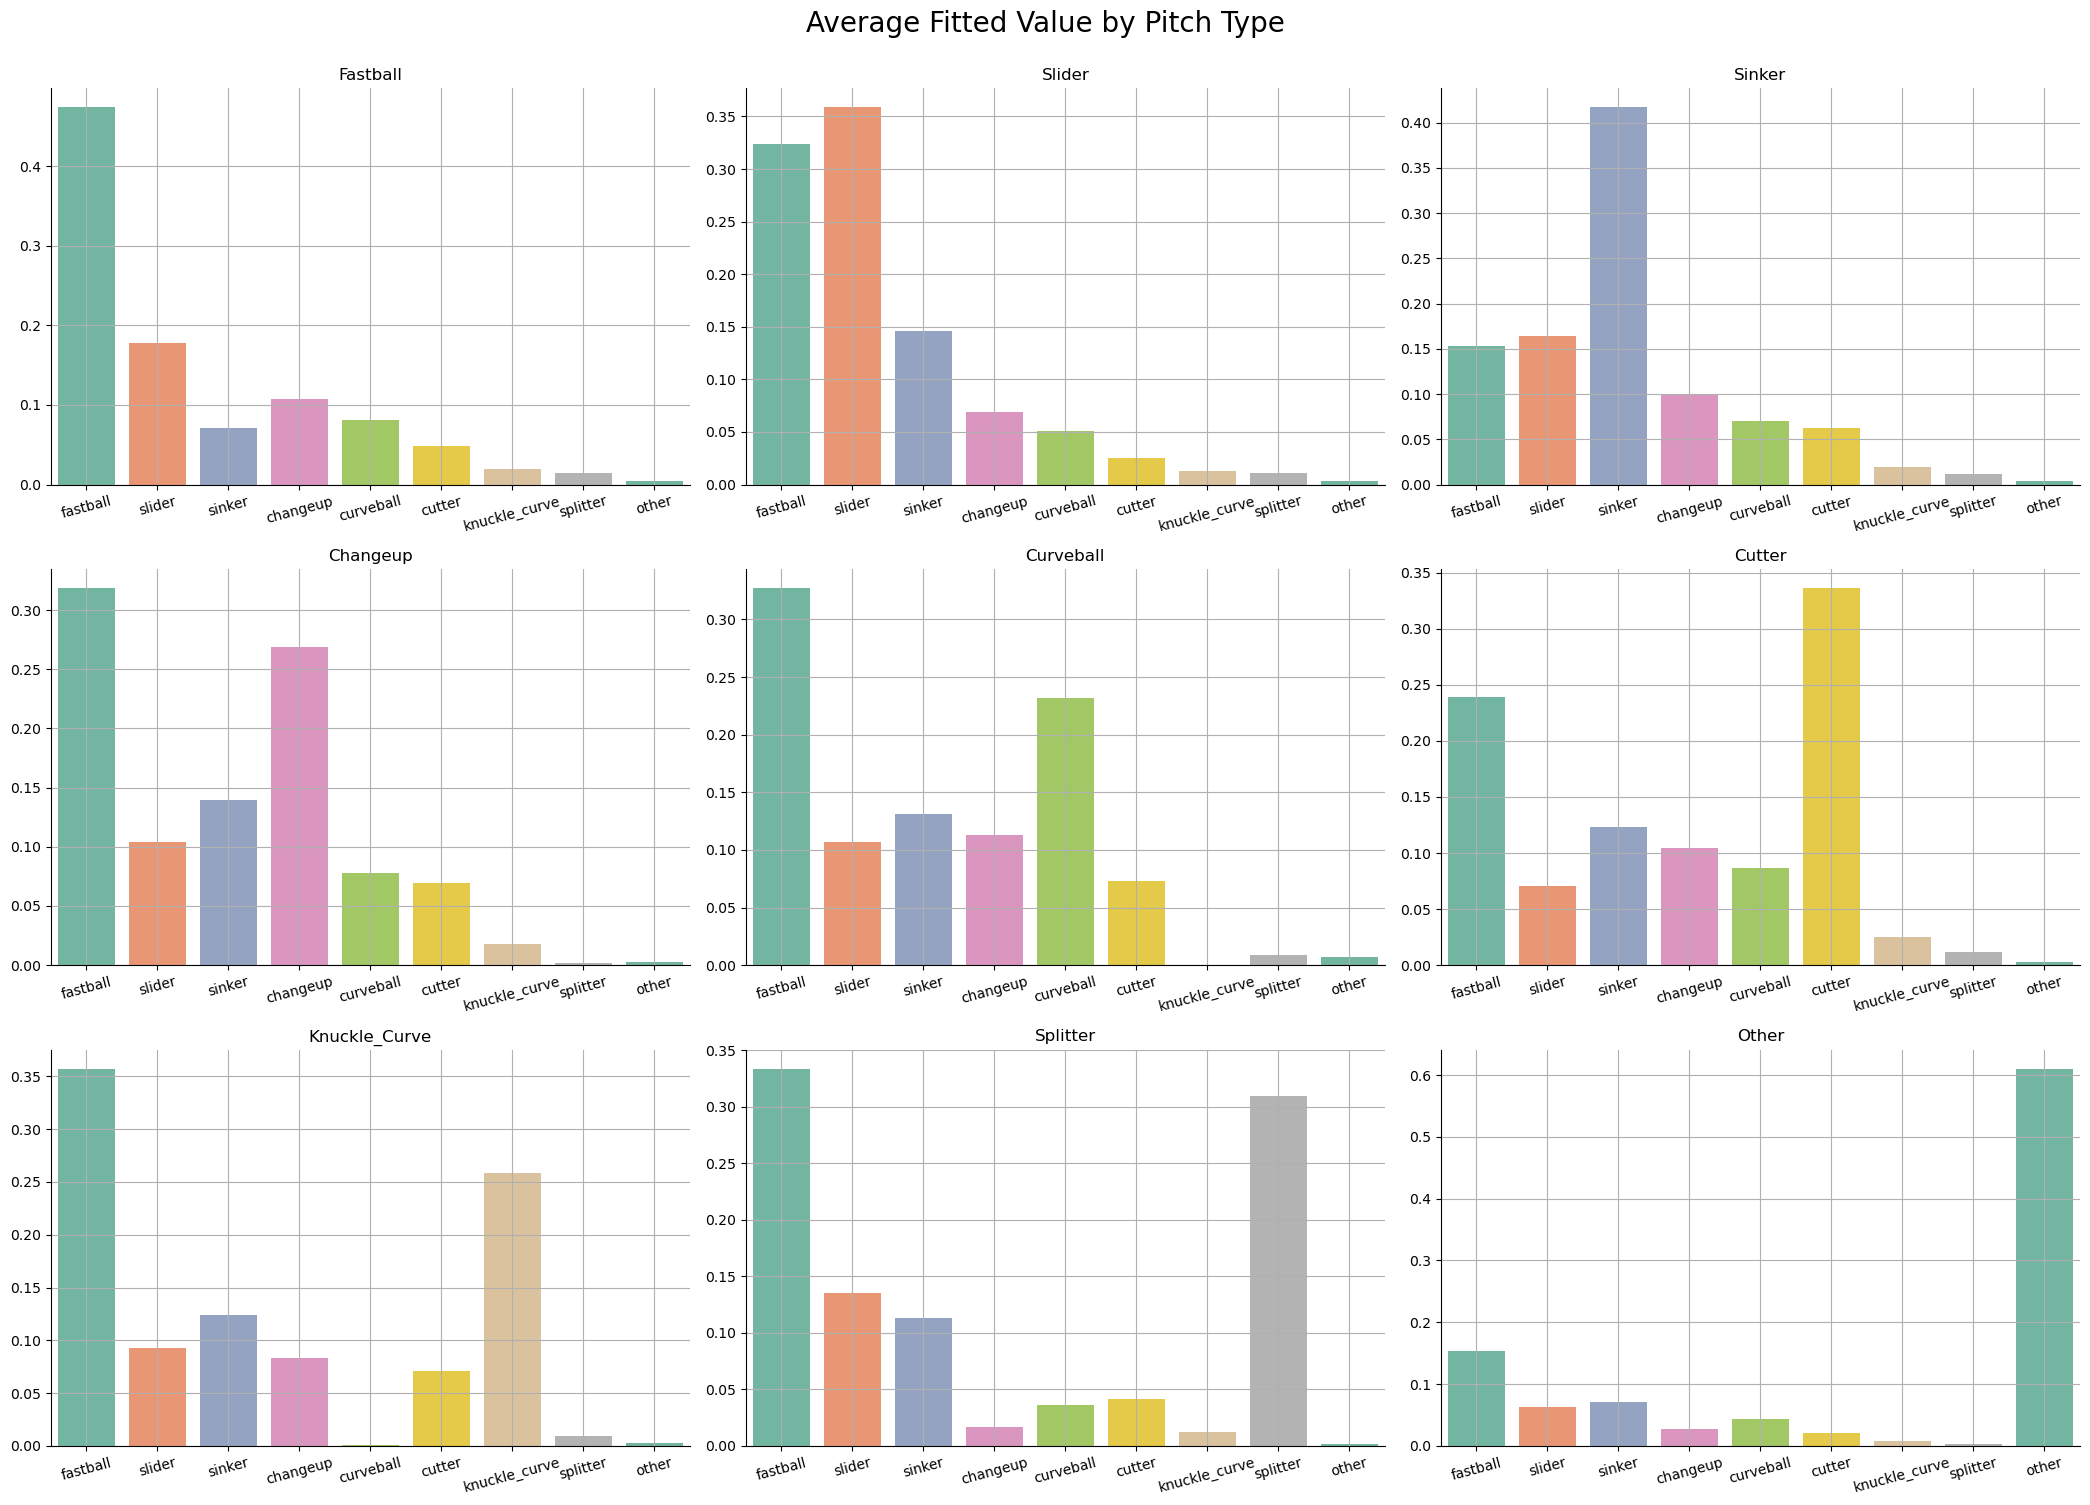

In [66]:
y_eval = y_hat.copy(deep=True)
y_eval['observed'] = y_val.idxmax(axis=1)
g = y_eval.groupby('observed').mean().reset_index()
g.sort_values('observed', key=lambda x: x.map(y_train.sum()), inplace=True, ascending=False)
g = g[['observed'] + list(y_train.sum().sort_values(ascending=False).index)].copy(deep=True) # reorder columns
g.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    probabilities = g.iloc[i]
    observed = probabilities.pop('observed')
    sns.barplot(x=probabilities.index, y=probabilities.values, ax=ax, palette='Set2')
    ax.set(title=observed.title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.grid()

fig.suptitle("Average Fitted Value by Pitch Type", fontsize=20, y=1)
plt.tight_layout()
sns.despine()



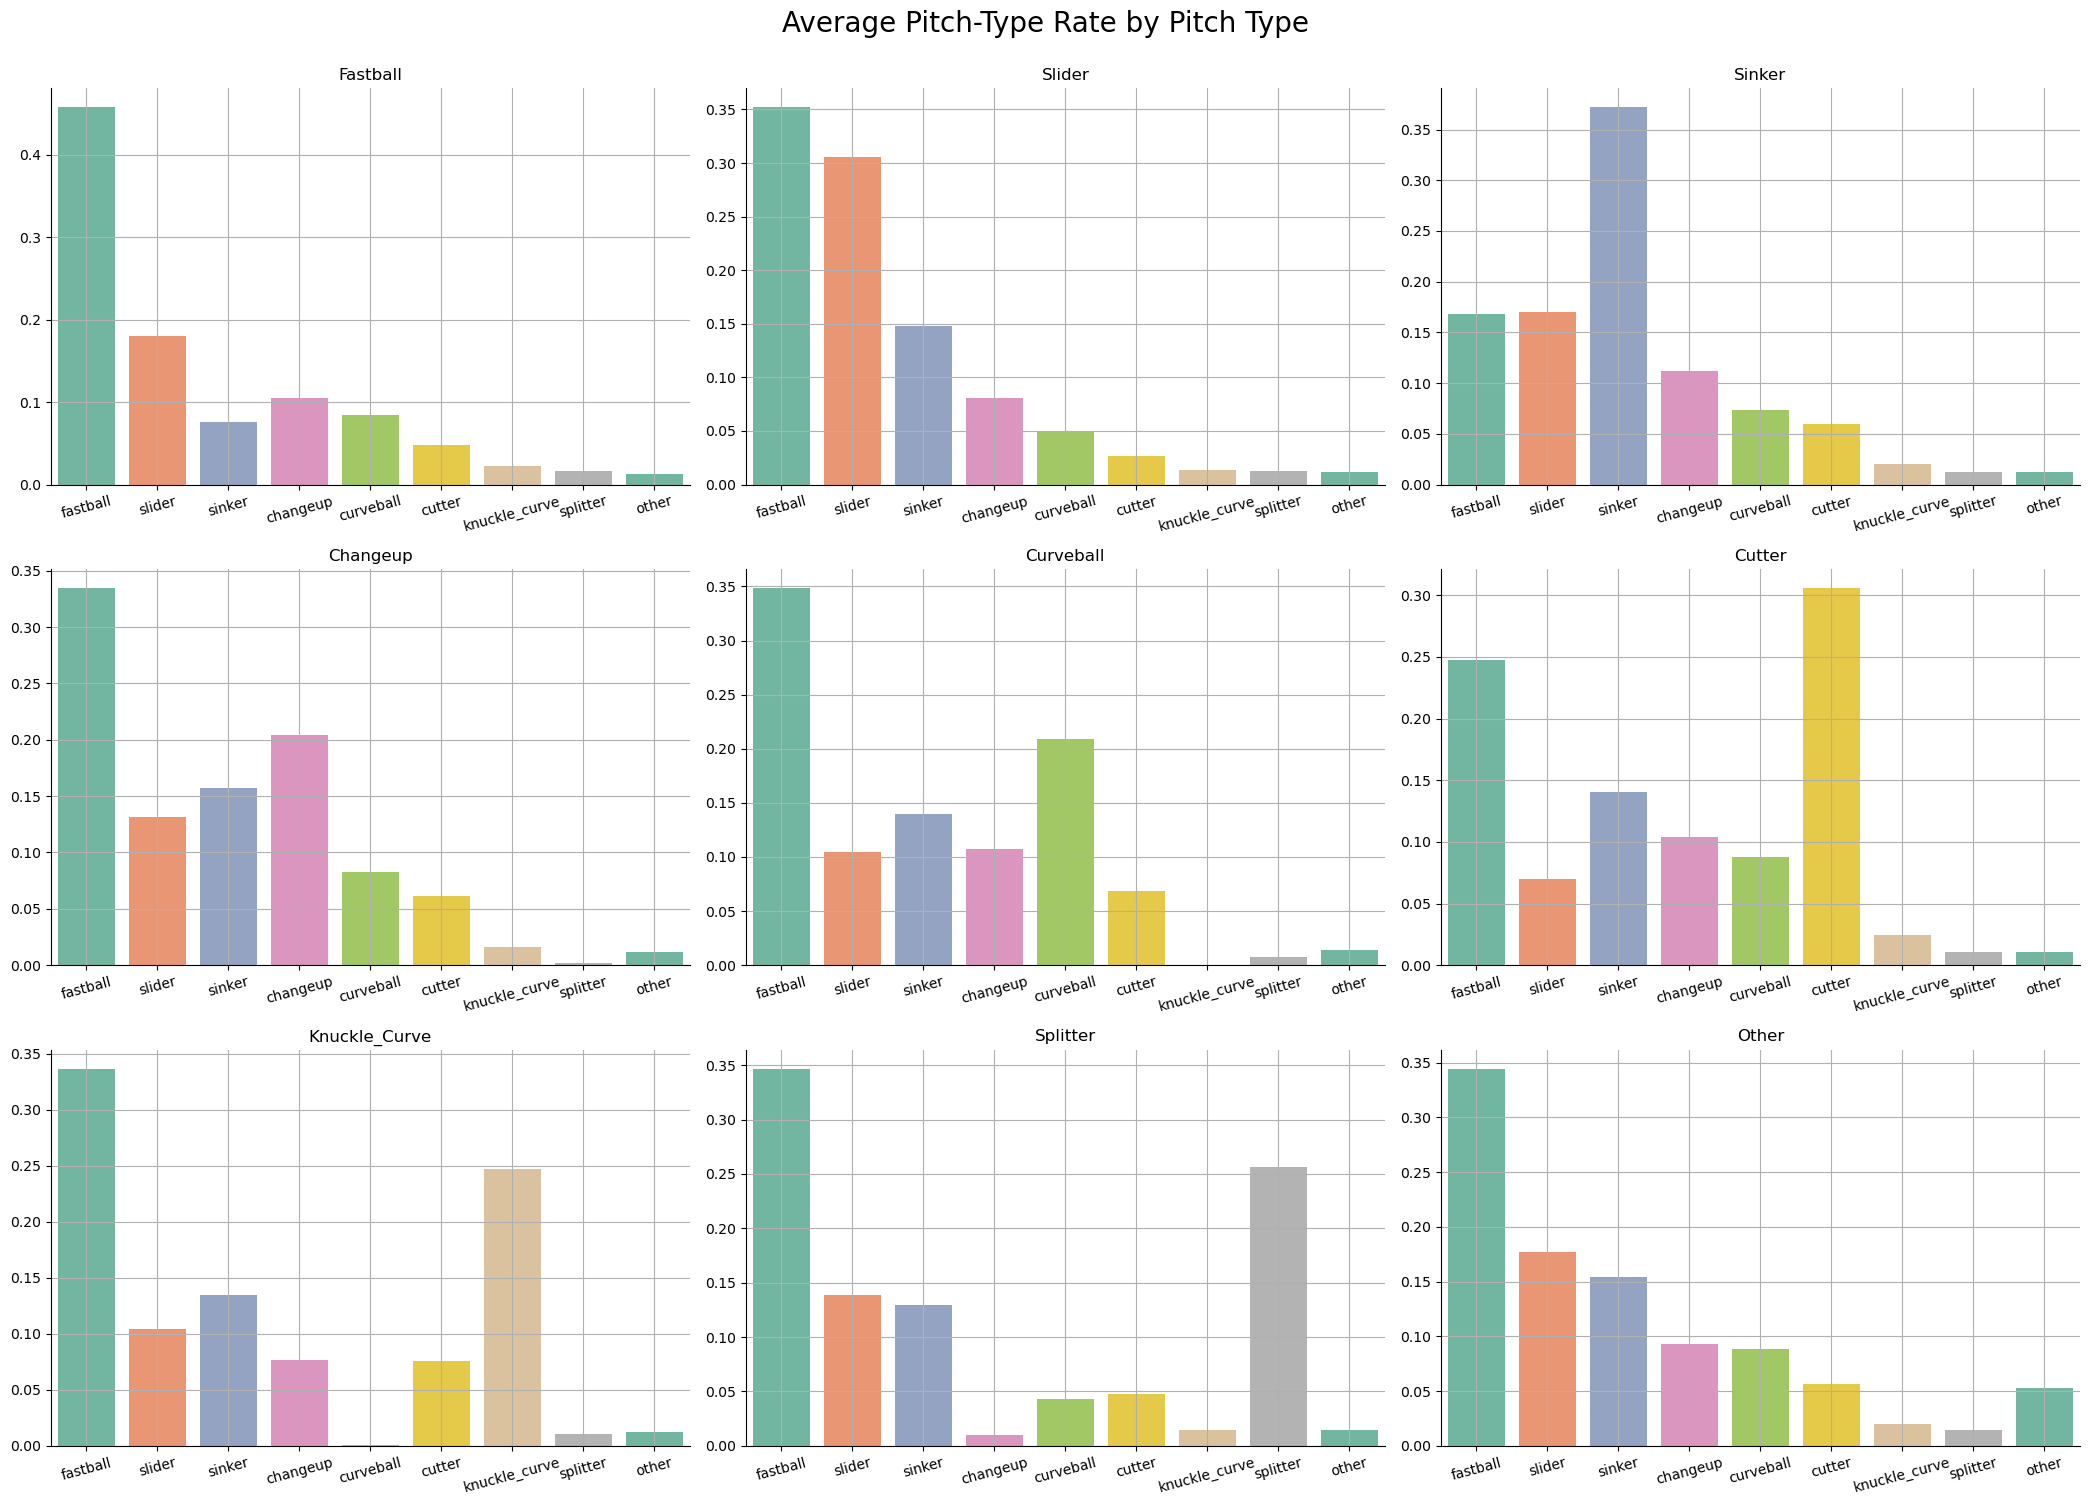

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(21, 15))
for i, ax in enumerate(axes.ravel()):
    pitch_type = mean_rate_by_type.index[i]
    mean_rates = mean_rate_by_type.iloc[i]
    sns.barplot(x=mean_rates.index, y=mean_rates.values, ax=ax, palette='Set2')
    ax.set(title=pitch_type.title())
    ax.set_xticklabels([x.get_text().replace("_rate", "") for x in ax.get_xticklabels()], rotation=15)
    ax.grid()
    
fig.suptitle("Average Pitch-Type Rate by Pitch Type", fontsize=20, y=1)
plt.tight_layout()
sns.despine()
